In [1]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/suneha/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [24]:
movies_filename = 'movies_scrape1.csv'
ratings_filename = 'scrape_review_score.csv'

In [25]:
df_movies = pd.read_csv(movies_filename,
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'int32'})

In [26]:
df_movies.loc[:15,:]

,movieId,title
0,1,Housefull 4
1,2,War
2,3,Bigil
3,4,Hotel Mumbai
4,5,Saand Ki Aankh
5,6,Ready Player One
6,7,Ghost
7,8,Jumanji: Welcome to the Jungle
8,9,Made in China
9,10,The Family Man


In [27]:
print(df_ratings.loc[:15,:] ,
"\n File dimensions ",df_ratings.shape)

    userId  movieId  rating
0        0      599      10
1        0      368       6
2        0      757       0
3        0       48      -3
4        0      530      -1
5        0      340       1
6        0       33       1
7        0      630       5
8        0      149       6
9        0      743      -1
10       0       31       2
11       0      917      12
12       0      968       2
13       0      409       4
14       0      165       6
15       0      766       1 
 File dimensions  (27570, 3)


In [28]:
# determining the number of unique users and movies in the dataset
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this dataset'.format(num_users, num_items))

There are 1000 unique users and 1103 unique movies in this dataset


In [29]:
# Getting the count of each type of rating
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
-36,2
-30,4
-26,4
-24,8
-21,12
-20,4
-19,6
-18,4
-17,18


In [9]:
# clearly the rating of 0 is missing. Therefore, adding 0s
# df_ratings.shape[0] indicates the number of rows in ratings table(userid movieid rating) i.e., total other ratings
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    #verify_integrity=True,
).sort_index()
df_ratings_cnt.head(2)


,count
-36.0,2
-30.0,4


Text(0, 0.5, 'number of ratings')

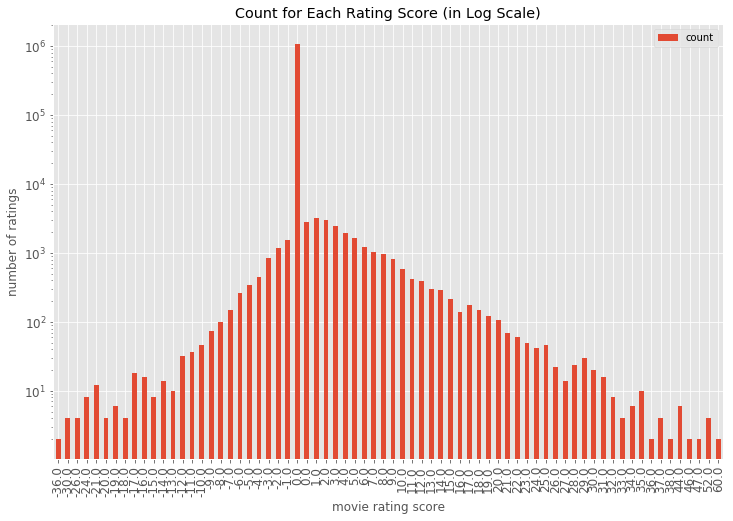

In [10]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings')

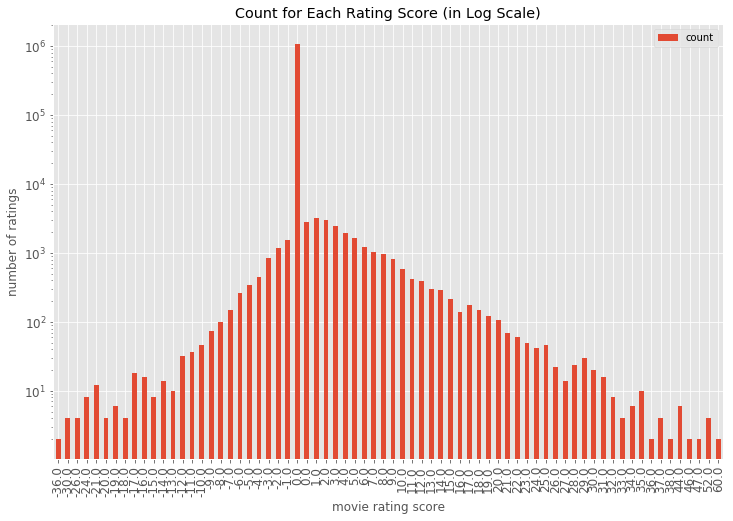

In [11]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [12]:
# get rating frequency for the movie
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()


,count
movieId,
0,25
1,25
2,25
3,25
4,25


In [13]:
# filtering data to get only popular items i.e., movies with > 2 ratings
popularity_thres = 5
df_movies_cnt.query('count >= @popularity_thres').head()
# returns movies > 20 ratings

,count
movieId,
0,25
1,25
2,25
3,25
4,25


In [15]:
df_movies_cnt.query('count >= @popularity_thres').index
# gives index of all the movies>20 ratings

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102],
           dtype='int64', name='movieId', length=1103)

In [16]:
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
# df_ratings.movieId.isin(popular_movies) gives boolean list with true ony where movie id is present in popular_movies

In [17]:
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (27570, 3)
shape of ratings data after dropping unpopular movies:  (27570, 3)


In [18]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
0,26
1,29
2,27
3,34
4,31


In [19]:
# filter data such that users who have rated > 50 movies are considered
ratings_thres = 0
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)
#print(df_ratings_drop_users.head())

shape of original ratings data:  (27570, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (27570, 3)


In [ ]:
df_ratings_drop_users.sort_values(by='movieId').head()

In [59]:
# pivot :  reshaping data(index->what field you want as rows, column->what fields you want as columns, values-> it will only show these fields)
# pivot_table : is used to summarize and aggregate data in dataframe
# pivot and create movie-user matrix
# Enumerate() method adds a counter to an iterable and returns it in a form of enumerate object. 
movie_user_mat = df_ratings.reset_index().pivot_table(index='movieId', columns='userId', values='rating', aggfunc = 'mean').fillna(0)
# create mapper from movie title to index mapper = dictionary
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
# csr matrix is a compressed representation of the matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)
if np.nan in movie_to_idx:
    del(movie_to_idx[np.nan])

/home/suneha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [ ]:
movie_user_mat.head()

In [60]:
# “No space left on device” error while fitting Sklearn model 
# This problem occurs when shared memory is consumed and no I/O operation is permissible. This is a frustrating problem that occurs to most of the Kaggle users while fitting machine learning models.
#I overcame this problem by setting JOBLIB_TEMP_FOLDER variable using following code.

%env JOBLIB_TEMP_FOLDER=/tmp

# n_neighbors : Number of neighbors to use

# algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, optional
# ‘brute’ will use a brute-force search.

# metric : string or callable, default ‘minkowski’
# metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.

# n_jobs : The number of parallel jobs to run for neighbors search. 
#  If set to -1, all CPUs are used.

# creating an instance of NearestNeighbours class
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

In [84]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
# fuzzywuzzy library where we can have a score out of 100, that denotes two string are equal by giving similarity index.
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
# ratio > 60 implies the presence of same words
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    #print(idx)
    #idx = idx<1000
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # numpy.squeeze() function is used when we want to remove single-dimensional entries from the shape of an array.
    # [:0:-1] (slicing) reversing the list 
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    #print(reverse_mapper[400])
    for i, (idx, dist) in enumerate(raw_recommends):
        #print(idx)
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [88]:
my_favorite = 'Mahanati'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=5)

You have input movie: Mahanati
Found possible matches in our database: ['Mahanati', 'Madaari', 'Mahabharat', 'Kahaani', 'Mohabbatein', 'Masti', 'Hatim', 'Maatr', 'Maharshi', 'Ramayana', 'Manto', 'Mamangam', 'Aadai', 'Magamuni', 'Om Shanti Om']

Recommendation system start to make inference
......

Recommendations for Mahanati:
1: Loev, with distance of 0.7850994043520302
2: C.I.D., with distance of 0.7795995376019531
3: Nautanki Saala!, with distance of 0.7669277629854028
4: That Girl in Yellow Boots, with distance of 0.7613141575595076
5: Gadar: Ek Prem Katha, with distance of 0.7358506906738812


In [89]:
my_favorite = 'Mission Mangal'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=5)

You have input movie: Mission Mangal
Found possible matches in our database: ['Mission Mangal', 'Missing', 'Mission Over Mars']

Recommendation system start to make inference
......

Recommendations for Mission Mangal:
1: Mardaani 2, with distance of 0.8852813195010892
2: Dil Chahta Hai, with distance of 0.8796485467255434
3: Fanney Khan, with distance of 0.8738738596956452
4: Climax, with distance of 0.8612823361411517
5: Bhoothnath Returns, with distance of 0.8558833552833611


In [90]:
my_favorite = 'Dil Chahta Hai'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=5)

You have input movie: Dil Chahta Hai
Found possible matches in our database: ['Dil Chahta Hai', 'Dil Hi Toh Hai', 'Dil To Pagal Hai', 'Dil Bechara']

Recommendation system start to make inference
......

Recommendations for Dil Chahta Hai:
1: Gadar: Ek Prem Katha, with distance of 0.8063485391671633
2: Chalte Chalte, with distance of 0.8029361861835721
3: Eklavya, with distance of 0.7924740555824183
4: Panipat, with distance of 0.7817283416492984


KeyError: 1005